This notebook mainly serves to load the pre-computed signal and background trials and then compute the best fit number of signal events, sensitivity and discovery potentials for various spectral indices. We are performing a transient, time-dependent stacking analysis. This analysis observes time windows that have a duration of 0.01 - 1e7 seconds AFTER the FRB has occurred. The sensitivities and discovery potentials are calculated and saved; they are then plotted in "Plots.ipynb". These sensitivities and discovery potentials below are calculated for the main catalog of 22 non-repeating FRBs

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import argparse
import histlite as hl
import csky as cy

ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.get_analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 10.0

a = ana.anas[0]

FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 
              2.811899957888065, 1.9050268785518107, 4.788485335771643, 
              5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623,
              6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, 
               -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, 
               -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, 
               -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

##### Defining functions to compute flux ######    
def ndarray_to_TSD(trials):
    return cy.dists.TSD(cy.utils.Arrays(trials))

def tsd_merge(x):
    ts_values = np.concatenate([xx[0] for xx in x])
    n_zero = sum(xx[1] for xx in x)
    return cy.dists.TSD(ts_values, n_zero=n_zero)

def find_n_sig(beta=0.9, nsigma=None):
    sig_trials = cy.bk.get_best(sig, 'n_sig')
    b = bg
    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)
    
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
        
    trials = {0: tr.get_many_fits(100)}
    trials.update(sig_trials)
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    
    return tr.to_E2dNdE(result, E0=1e5)

Setting up Analysis for:
MESC_2010_2016
Setting up MESC_2010_2016...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_MC.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2014_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2015_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/

Below, we are calculating the fluxes for the catalog of 22 non-repeating FRBs

In [4]:
#The time windows that we wish to use to search for neutrino emission
time_windows = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0]

sens_gamma_2, disc_pot_nsigma_3_gamma_2, disc_pot_nsigma_5_gamma_2 = [],[],[]

for i in time_windows:
    print(i)
    
    #We will calculate the sensitivity, 3-sigma discovery potential and 5-sigma discovery potential
    fluxs_sens, disc_pot_flux_nsigma_3, disc_pot_flux_nsigma_5 = [], [], []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 2.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/trials/sig/gamma/2.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)

    fluxs_sens = find_n_sig(beta=0.9)
    sens_gamma_2.append(fluxs_sens)
    
    disc_pot_flux_nsigma_3 = find_n_sig(beta = 0.9, nsigma = 3)
    disc_pot_nsigma_3_gamma_2.append(disc_pot_flux_nsigma_3)
    
    disc_pot_flux_nsigma_5 = find_n_sig(beta = 0.9, nsigma = 5)
    disc_pot_nsigma_5_gamma_2.append(disc_pot_flux_nsigma_5)
    
    print('sens = ' + str(fluxs_sens))

sens_gamma_3, disc_pot_nsigma_3_gamma_3, disc_pot_nsigma_5_gamma_3 = [],[],[]

for i in time_windows:
    print(i)
    fluxs_sens, disc_pot_flux_nsigma_3, disc_pot_flux_nsigma_5 = [], [], []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 3.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/trials/bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/trials/sig/gamma/3.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)
    
    fluxs_sens = find_n_sig(beta=0.9)
    sens_gamma_3.append(fluxs_sens)
    
    disc_pot_flux_nsigma_3 = find_n_sig(beta = 0.9, nsigma = 3)
    disc_pot_nsigma_3_gamma_3.append(disc_pot_flux_nsigma_3)
    
    disc_pot_flux_nsigma_5 = find_n_sig(beta = 0.9, nsigma = 5)
    disc_pot_nsigma_5_gamma_3.append(disc_pot_flux_nsigma_5)
    
    print('sens = ' + str(fluxs_sens))

Now we are calculating and saving the fluxes for the FRB121102 catalog

In [2]:
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 10.0

#Ordinarily, dt and gamma are passed as arguments so they are not usually declared as constants, uncomment code below for testing/check purposes
dt = 0.1
gamma = 3.0

#loading analysis object to get mjd of time data-set and events
a = ana.anas[0]

FRB_mjd_time = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_mjd.npy', allow_pickle = True)

FRB_ra_rad = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_RA.npy', allow_pickle = True)

FRB_dec_rad = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_DEC.npy', allow_pickle = True)

FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

print("Starting Trials")

##### Defining functions to compute flux ######    
def ndarray_to_TSD(trials):
    return cy.dists.TSD(cy.utils.Arrays(trials))

# Since we have 1e9 background trials, it requires a large amount of RAM to load them. To circumvent this, 
# we only count the number of background trials that have a TS = 0 instead of loading every 0.
def tsd_merge(x):
    ts_values = np.concatenate([xx[0] for xx in x])
    n_zero = sum(xx[1] for xx in x)
    return cy.dists.TSD(ts_values, n_zero=n_zero)

def find_n_sig(beta=0.9, nsigma=None):
    # get signal trials, background distribution, and trial runner
    sig_trials = cy.bk.get_best(sig, 'n_sig')
    b = bg
    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)
    # determine ts threshold
    if nsigma is not None:
        ts = b.isf_nsigma(nsigma)
    else:
        ts = b.median()
    # including a trivial number of background trials in calculation since we initially got rid of all the 0's (only counting the total amount of 0's)
    trials = {0: tr.get_many_fits(10000)}
    trials.update(sig_trials)
    # get number of signal events
    result = tr.find_n_sig(ts, beta, max_batch_size=0, logging=False, trials=trials, n_bootstrap=1)
    # return flux
    return tr.to_E2dNdE(result, E0=1e5)

Starting Trials


In [6]:
time_windows = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0] #, 1000000.0, 10000000.0]

FRB_121102_gamma_3_sens, FRB121102_disc_pot_nsigma_3_gamma_3, FRB121102_disc_pot_nsigma_5_gamma_3 = [],[],[]
for i in time_windows:
    print(i)
    FRB121102_disc_pot_flux_nsigma_3, FRB121102_disc_pot_flux_nsigma_5 = [], []
    fluxs_sens = []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 3.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/sig/gamma/3.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)
    fluxs_sens = find_n_sig(beta=0.9)
    FRB_121102_gamma_3_sens.append(fluxs_sens)
    print('sens = ' + str(fluxs_sens))
    
    FRB121102_disc_pot_flux_nsigma_3 = find_n_sig(beta = 0.9, nsigma = 3)
    FRB121102_disc_pot_nsigma_3_gamma_3.append(FRB121102_disc_pot_flux_nsigma_3)
    
    FRB121102_disc_pot_flux_nsigma_5 = find_n_sig(beta = 0.9, nsigma = 5)
    FRB121102_disc_pot_nsigma_5_gamma_3.append(FRB121102_disc_pot_flux_nsigma_5)
    
np.save('/data/user/mkovacevich/FRB_analysis/FRB121102_disc_pot_nsigma_3_gamma_3', FRB_121102_gamma_3_sens, allow_pickle = True )
np.save('/data/user/mkovacevich/FRB_analysis/FRB121102_disc_pot_nsigma_5_gamma_3', FRB121102_disc_pot_nsigma_3_gamma_3, allow_pickle = True)
np.save('/data/user/mkovacevich/FRB_analysis/FRB_121102_gamma_3_sens', FRB121102_disc_pot_nsigma_5_gamma_3, allow_pickle = True)


FRB_121102_gamma_2_sens, FRB121102_disc_pot_nsigma_3_gamma_2, FRB121102_disc_pot_nsigma_5_gamma_2 = [],[],[]
for i in time_windows:
    print(i)
    FRB121102_disc_pot_flux_nsigma_3, FRB121102_disc_pot_flux_nsigma_5 = [], []
    fluxs_sens = []
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.
    gamma = 2.0
    bg = cy.bk.get_all(
    '/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/bg/dt/'+str(i)+'/',
    'bg_trials_seed_*.0.npy',
    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),
    merge = tsd_merge,
    log=True)
    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/sig/gamma/2.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)
    fluxs_sens = find_n_sig(beta=0.9)
    FRB_121102_gamma_2_sens.append(fluxs_sens)
    print('sens = ' + str(fluxs_sens))
    
    FRB121102_disc_pot_flux_nsigma_3 = find_n_sig(beta = 0.9, nsigma = 3)
    FRB121102_disc_pot_nsigma_3_gamma_2.append(FRB121102_disc_pot_flux_nsigma_3)
    
    FRB121102_disc_pot_flux_nsigma_5 = find_n_sig(beta = 0.9, nsigma = 5)
    FRB121102_disc_pot_nsigma_5_gamma_2.append(FRB121102_disc_pot_flux_nsigma_5)
    
np.save('/data/user/mkovacevich/FRB_analysis/FRB121102_disc_pot_nsigma_3_gamma_2', FRB_121102_gamma_2_sens, allow_pickle = True )
np.save('/data/user/mkovacevich/FRB_analysis/FRB121102_disc_pot_nsigma_5_gamma_2', FRB121102_disc_pot_nsigma_3_gamma_2, allow_pickle = True)
np.save('/data/user/mkovacevich/FRB_analysis/FRB_121102_gamma_2_sens', FRB121102_disc_pot_nsigma_5_gamma_2, allow_pickle = True)


0.01
2000 files loaded.                                                                            
1900 files loaded.                                                                                             
Performing 10000 background trials using 10.0 cores:
      10000/10000 trials complete.   
sens = 0.10395122586343923
Performing 10000 background trials using 10.0 cores:
      10000/10000 trials complete.   
Performing 10000 background trials using 10.0 cores:
      10000/10000 trials complete.   
0.1
2000 files loaded.                                                                           
1900 files loaded.                                                                                            
Performing 10000 background trials using 10.0 cores:
      10000/10000 trials complete.   
sens = 0.10258962638365314
Performing 10000 background trials using 10.0 cores:
      10000/10000 trials complete.   
Performing 10000 background trials using 10.0 cores:
      10000/10000

"\n\nFRB_121102_gamma_2_sens, FRB121102_disc_pot_nsigma_3_gamma_2, FRB121102_disc_pot_nsigma_5_gamma_2 = [],[],[]\nfor i in time_windows:\n    print(i)\n    FRB121102_disc_pot_flux_nsigma_3, FRB121102_disc_pot_flux_nsigma_5 = [], []\n    fluxs_sens = []\n    dt = i\n    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.\n    gamma = 2.0\n    bg = cy.bk.get_all(\n    '/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/bg/dt/'+str(i)+'/',\n    'bg_trials_seed_*.0.npy',\n    pre_convert=lambda x: (x['ts'][x['ts'] > 0], np.sum(x['ts'] == 0)),\n    merge = tsd_merge,\n    log=True)\n    sig = cy.bk.get_all('/data/user/mkovacevich/FRB_analysis/FRB_121102_trials/sig/gamma/2.0/dt/'+str(i)+'/','sig*npy', merge=np.concatenate, post_convert=cy.utils.Arrays)\n    fluxs_sens = find_n_sig(beta=0.9)\n    FRB_121102_gamma_2_sens.append(fluxs_sens)\n    print('sens = ' + str(fluxs_sens))\n    \n    FRB121102_disc_pot_flux_nsigma_3 = find_n_sig(beta = 0.9, nsigma = 3)\n    FRB121102_disc_pot_nsigma

Below, we make a skymap of the FRBs used in this analysis. We are analyzing two different catalogs and so we wish to plot both of them below. This plto corresponds to the FRB Sky Plot shown in my analysis wiki.

/home/mkovacevich/py3venv/lib/python3.7/site-packages/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


AttributeError: 'PathCollection' object has no property 'xycoords'

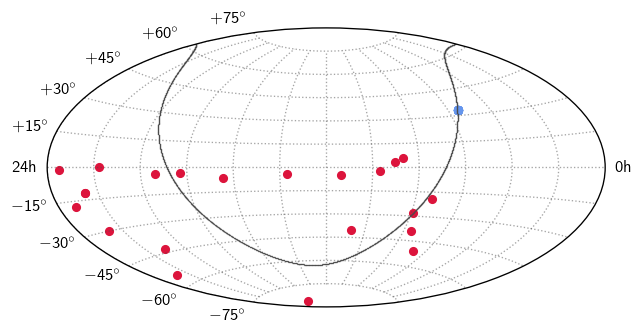

In [11]:
FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 
              2.811899957888065, 1.9050268785518107, 4.788485335771643, 
              5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623,
              6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, 
               -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, 
               -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, 
               -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

FRB_repeated_ra_rad = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_RA.npy', allow_pickle = True)
FRB_repeated_dec_rad = np.load('/data/user/mkovacevich/FRB_analysis/FRB_121102_DEC.npy', allow_pickle = True)

all_FRBs_ra = np.concatenate((FRB_repeated_ra_rad, FRB_ra_rad))
all_FRBs_dec = np.concatenate((FRB_repeated_dec_rad, FRB_dec_rad))

src = cy.utils.Sources(ra=all_FRBs_ra,dec=np.array(all_FRBs_dec))
cy.plotting.mrichman_mpl()

fig, ax = plt.subplots (subplot_kw=dict (projection='aitoff'))
for ra, dec in zip(FRB_ra_rad, FRB_dec_rad):
    ax.scatter(np.pi - ra, dec, marker = 'o', s= 20, color = 'crimson' )
ax.scatter(np.pi - FRB_repeated_ra_rad, FRB_repeated_dec_rad, marker = 'o', s= 20, color = 'cornflowerblue' )
sp = cy.plotting.SkyPlotter(pc_kw=dict(cmap=cy.plotting.skymap_cmap, vmin=0, vmax=10))
kw = dict(color='.3', alpha=.5)
sp.plot_gp(ax, lw=.5, **kw)
ax.grid(**kw)

def yfmt(n, *a):
    n = np.degrees(n)
    fmt = r'${:+.0f}^\circ$'
    return fmt.format(n) if n else ''

ax.xaxis.set_ticks(np.radians(np.arange(-180, 180, 30)))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda *a: ''))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(yfmt))
kw = dict(xycoords='axes fraction', textcoords='offset pixels', verticalalignment='center')
ax.annotate(r'0h', xy=(1, .5), xytext=(10, 0), horizontalalignment='left', **kw)
ax.annotate(r'24h', xy=(0, .5), xytext=(-10, 0), horizontalalignment='right', **kw)
sp.plot_gc(ax, **kw)
ax.grid(**kw)
plt.tight_layout()
plt.savefig('/home/mkovacevich/public_html/Qual/FRBskymap.png')